<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/NMR_Deep_Learning/01_nmr_deep_learning_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMR Spectrum Analysis Using Artificial Neural Networks


---


#### Authored by Sebastian W. Atalla
##### UNC Chapel Hill | Dept. of Physics & Astronomy

*The content of this notebook is computationally expensive, and is best experienced with a GPU-accelerated runtime. Such a runtime is available via Google Colab. To open this notebook in a Colab environment, follow the badge above.*

## **Background**

The Fourier transform is one of the most important concepts in signal processing. It translates an acquired signal between its time and frequency domain representations, allowing for the decomposition of a signal into its constituent frequencies, or construction of a signal from those frequencies.

The Fourier transform, $F(k)$, and its inverse transformation, $f(x)$, are generally given by

\begin{equation}
  F(k) = \int_{-\infty}^{\infty} f(x) \, e^{-2\pi i k x} \, dx  
  \qquad \qquad
  f(x) = \int_{-\infty}^{\infty} F(k) \, e^{2\pi i k x} \, dk
\end{equation}

respectively. The Fourier transform as as defined above may be naively computed via the discrete Fourier transform (DFT) and its inverse transformation,

\begin{equation}
  X_k = \sum_{n=0}^{N-1} x_n \, e^{-i\frac{2\pi}{N}kn}
  \qquad \qquad
  x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k \, e^{i\frac{2\pi}{N}kn}
\end{equation}

respectively; however, this is remarkably ineffificent compared to the modern fast Fourier transform (FFT) utilized in practically all computational domains.

The Fourier transform is used to great effect in nuclear magnetic resonance (NMR) spectroscopy, which exploits the fact that different atomic species resonate at different frequencies in a magnetic field as defined by their gyromagnetic ratio – a phenomenon known as spin precession. Faraday induction is used to detect the precession of the magnetization vector of the nuclear spins, which yields the magnetization amplitude as a function of time. The DFT decomposes this signal into discrete frequencies that may be interpreted in terms of chemical shift, which is a field-independent representation of a nucleus’s resonant frequency.

This same principle is utilized heavily in magnetic resonance imaging (MRI), in which images are reconstructed via a 2-dimensional FFT from data collected by the MRI machine in *k-space*, which represents spatial frequencies in the acquired image.

## Deep Learning Applications

Deep learning is a sub-discipline of machine learning that encompasses the concept of neural networks. Theoretically, neural networks scale better than traditional computational methods for large amounts of data. This is particularly important for signal processing, since some datasets (e.g., magnetic resonance imaging data) can be extremely large. Deep learning algorithms attempt to learn features about the data; however, in the context of traditional computation and the DFT, the features are intrinsic to the signal. Therein arises the point of this module – can a neural network estimate the frequency content of a signal? 

### **Disclaimer**

The FFT algorithm is efficient and exact. Practically, the Fourier transform is a poor application of deep learning; however, the exactness of the computation (which provides a ground truth for the network's predictions) and the litany of features that may be discerned from the data render it a good thought experiment for learning about neural net architecture and feature engineering.

## Preparation

**Execute these cells to initialize notebook**. These cells import packages, define constants, and instantiate generators used in the following cells.

In [1]:
# Computation
import numpy as np
from numpy.random import default_rng
import scipy
import scipy.optimize
import scipy.signal
import scipy.integrate

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb

#  Machine learning
import tensorflow as tf
from tensorflow import keras

In [2]:
# If problems arise while editing NN parameters, run this cell to clear persistent graph data.
tf.keras.backend.clear_session()

In [3]:
# Define a constant for pi since `np.pi` is clumsy, and it's preferable to not import it
PI = np.pi

# Random generator
rng = np.random.default_rng()

# **Exercise 1** Estimation of FID Frequency Content from FFT

This exercise explores the fidelity of a neural network trained on an NMR signal and the frequency content from that signal's FFT. The signals are simulated from the expression describing a free induction decay (FID), a waveform prevalent in the common single-pulse sequences used in NMR spectroscopy.

An FID may be described by

\begin{equation}
  \text{FID} = \sin{(\omega_0 t)} \, e^{-t/T_2^*}
\end{equation}

where $\omega_0$ and $t$ are of the usual formulation in signal processing, and $T_2^*$ is the effective decay in transverse magnetization of the nucleus being measured.

The NMR spectrometer detects a signal as a series of voltages, which must be digitized by an analog-to-digital (ADC) converter, which binarizes the signal for use on a computer. Sampling by the ADC occurs in regular intervals, which yields the datapoints seen in the FID.

The sampling rate of the ADC must be fast enough that important information in the signal is not lost. The minimum sampling frequency, $f_{s_{min}}$, needed to render an accurate signal is

\begin{equation}
  f_{s_{min}} \equiv f_{N} = 2f_{max}
\end{equation}

where $f_{N}$ is the *Nyquist frequency* and $f_{max}$ is the highest sampled frequency.

The Nyquist limit is problematic because NMR frequencies are on the order of megahertz. An ADC cannot digitize fast enough to capture this signal. The solution to this is *RF mixing*, in which two frequencies (typically the observed frequency and a reference frequency) are multiplied to yield sinusoids of sums and differences of the two frequencies,

\begin{equation}
  A\cos{(\omega_0 t)} \, \times \, A\cos{(\omega_{rx} t)} =
  \frac{1}{2}A \big[ \cos{ \big( (\omega_0 + \omega_{rx})t \big)}\big] + \cos{ \big( (\omega_0 - \omega_{rx})t \big)}\big]
\end{equation}

where $\omega_0$ is the Larmor frequency, and $\omega_{rx}$ is the reference frequency. After applying a low-pass filter, the signal of interest is now simply

\begin{equation}
  S = \frac{1}{2}A\left[\cos{ \big( (\omega_0 - \omega_{rx})t \big)}\right] = \frac{1}{2}A\left[\cos{ (\omega_{\text{mix}})t)}\right]
\end{equation}

in which $\omega_{\text{mix}}$ is a frequency that may now be sampled by the ADC.

## Signal Data

The FIDs will be simulated from an array of RF-mixed frequencies spanning 50 Hz to 1 kHz. A series of $T_2^*$ relaxation times will also be used to emulate the spectra in various media (e.g. tissue, water, fat, etc.). 

In [4]:
# RF=mixed frequencies from 50 Hz to 1 kHz
rf_mix_frequency = np.linspace(50, 1000, num=50, endpoint=True)

# T2 spin-spin relaxation times for proton in various media
spin2_relaxation = np.linspace(0.1, 4, num=25, endpoint=True) # Seconds

# Nyquist limit for highest frequencu; satisfies all Nyquist limit reqs. for lower frequencies
min_sampling_freq = 2 * rf_mix_frequency.max() # Hertz

# Sampling that satisfies the Nyquist limit for the highest RF-mixed frequency
time = np.arange(0, 1, 1/(2*min_sampling_freq)) # Seconds

In [5]:
def fid_sim(w0, t, T2, phase_shift = 0):
   """ Simulates a free induction decay (FID). """
   return np.sin(2*PI * w0 * t + phase_shift) * np.exp(-t/T2)

In [6]:
# At least one of the args needs to be Iterable to make a table; for simplicity, enforce it on all args
def make_fid_table(frequency, timepts, relaxation):
   """ Constructs a table of simulated FIDs. """
   # Use list for efficient append
   fid_table = []

   # `sz_dim` is the number of signals generated
   sz_dim = len(frequency) * len(relaxation)

   # Generate amplitude scaling and phase shifting factors to introduce more variance
   amplitude_scale_table   = rng.uniform(1, 10, sz_dim)
   phase_shift_table       = rng.uniform(0, 2*PI, sz_dim)

   # Iterate over each relaxation time for each frequency
   for w0 in frequency:
      for t2 in relaxation:
         # Randomly select an amplitude scaling factor and phase shift
         amp = rng.choice(amplitude_scale_table)
         phi = rng.choice(phase_shift_table)

         # Generate fid and append to the FID table
         fid = amp * fid_sim(w0, timepts, t2, phase_shift=phi)
         fid_table.append(fid)

   # Cast the list to an ndarray
   fid_table = np.asarray(fid_table)

   # Add some Gaussian noise to better simulate a real signal
   noise = rng.normal(-0.05, 0.05, fid_table.shape)
   noisy_fid = fid_table + noise

   # Shuffle the generated FIDs
   rng.shuffle(noisy_fid)

   return noisy_fid

The following cell contains the simulated FIDs.

In [7]:
full_fid_table = make_fid_table(rf_mix_frequency, time, spin2_relaxation)

In [8]:
# Table of simulated FIDs to serve as observed NMR spectra.
full_fid_table = make_fid_table(rf_mix_frequency, time, spin2_relaxation)

acq_fid_num = int(np.ceil(0.95 * len(full_fid_table)))

observed_fid_table = full_fid_table[0:acq_fid_num]
test_fid_table = full_fid_table[acq_fid_num:]

The next step is to compute the Fourier transform of the FIDs that have just been generated. 

In [9]:
def make_window(arr):
    """ Windows the input array relative to a signal's upper Nyquist band. """
    return arr[:int(np.ceil(len(arr)/2))]

def transform_fid_table(fid_table):
    """ Computes the forward FFT of the input FID array and returns the upper Nyquist band. """
    # Use a list for efficient append
    fid_transform_table = []

    # Iterate over each FID in the FID table
    for fid in fid_table:
        # Computes forward FFT and scales with the FID length
        fid_ft      = np.fft.fft(fid)/len(fid)
        # Collects complex modulus of the frequency-domain signal
        abs_ft      = np.abs(fid_ft)
        # Windows the FFT output to the upper Nyquist band
        win_fid_ft  = make_window(abs_ft)

        fid_transform_table.append(win_fid_ft)

    # Cast the list to an ndarray
    transformed_fid_table = np.asarray(fid_transform_table)

    return transformed_fid_table

The following cell contains the Fourier transforms of the generated FIDs.

In [10]:
ft_table = transform_fid_table(observed_fid_table)

The following cell is the frequency range of the signals, respective to the minimum sampling rate dictated by the highest frequency with which the FIDs were generated.

In [11]:
# Frequency range based on Nyquist limit
xfrq = make_window(np.fft.fftfreq(n=len(time), d=1/(2*min_sampling_freq)))

## The Neural Network

Can a neural network learn to decipher the frequency content of an observed FID? The first attempt will make use of simple artificial neural network (ANN) architecture trained on the FIDs and their respective FFT. This neural network consists of sequential dense, or fully-connected, layers which forms the *model*. The dense layers have several tunable parameters, otherwise known as *hyperparameters*. The `Dense` layer is defined in Keras as

```python
tf.keras.layers.Dense(
    units,
    activation = None,
    use_bias = True,
    kernel_initializer = "glorot_uniform",
    bias_initializer = "zeros",
    kernel_regularizer = None,
    bias_regularizer = None,
    activity_regularizer = None,
    kernel_constraint = None,
    bias_constraint = None,
    **kwargs)
```
where the arguments provided represent the default values instantiated by Keras.

Some of the most commonly tuned hyperparameters are `units`, which corresponds to the output dimensions of the layer (i.e. the number of *nodes*), and `activation` to specify which activation function should be used. The number of layers in the model is also a tunable hyperparameter.

An important note about hyperparameters is that they are not universally constant - they require tuning by the user. This means that a network will potentially undergo many iterations before the quality of its predictions is satisfactory to the user.


The largest hurdle in developing a neural network is understanding what the network is supposed to be solving. In the forward direction, the FFT is a linear transformation between the time-domain and frequency-domain representations of a signal. Thus, it behaves more like a regression than a classification. This immediately limits our choice of activation function, making the `activation` hyperparameter simple to tune.

Keras maintains several activation functions. Some of the most popular are `sigmoid`, `softmax`, `relu`, and `tanh`. Functions such as `sigmoid` and `softmax` are more useful in the final layer of network classifers, since they normalize the output to a probability distribution. That means `relu`-type and `linear` activation functions are preferred for regression problems, since they *generally* allow the output to remain unconstrained between $-\infty$ and $\infty$.

An exaustive list of Keras's activation functions and short descriptions of each may be found in the [Keras Activation Function API](https://keras.io/api/layers/activations/#available-activations) documentation.

### Exercise 1

The ANN below is able to learn an FID's frequency content, but it has trouble learning the amplitude and spectral-width of the center frequency. Adjust the parameters shown in the `Dense` API listed above. 

*   Focus primarily on layer `units` and activation functions.
*   Leave the initializers as default - these specify how the weights and biases are initialized in the model.

#### **Layers**
A neural network is expressed as a *model* composed of *layers*. The first layer in a network is the *input layer*, and the last layer is the *output layer*. The layers in between are the *hidden layers*, and is where the network's "learning" occurs. Each layer is comprised of *nodes*.

Nodes simply hold a number. For the input layer, this number is the input feature itself; for instance, it could be the intensity of a pixel in an image, or a value in a vector of data. This number is also known as the *activation* - called $h_{n}^{(k)}$ henceforth, where $n$ is the index of the node in a layer of $N$ nodes (or features), and $k$ is the index of the layer in which that node resides. The network learns parameters called weights, $w_{n}$, which are used to weight the activation of a node in the previous layer and feed it forward to the next layer. The weights help the network determine which features are most important. In the `Dense` layers used in this network, each node is fully connected to the nodes of the next layer. Thus, each node in some layer $k$ after the input contains a value expressed by

\begin{equation}
  h_{n}^{(k+1)} = \sum_{n=1}^{N}\,h_{n}^{(k)}w_{n,k}
\end{equation}

Depending on the data on which the network is learning, there may be additional requirements to satisfy activation of a node, such as a numeric threshold. A *bias* term may be added to the weighted sum describing a node's activation, such that the activation expression for a node may now be expressed as

\begin{equation}
  h_{n}^{(k+1)} = b_n + \sum_{n=1}^{N}\,h_{n}^{(k)}w_{n,k}
\end{equation}

in which $b_n$ shifts the value of the weighted sum to account for some bias. For example, if the threshold for activation is desired to be $h_{n}^{(k)} > 5$, the bias term would be $b_n = -5$.

Typically, the number of nodes in the input layer corresponds to the number of features in the input data, and the number of nodes in the output layer is equal to the number of solutions to the problem being solved. For example, in a network classifying whether an animal is a dog or a cat, the input layer may be the dimensions of 3 features - length, weight, and fur color - and the output layer may consist of 2 nodes, 1 for "dog" and 1 for "cat": 

![Network Diagram](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/NMR_Deep_Learning/Resources/network2.png?raw=true)

This is an example of a network with 3 inputs, $x_n$, and a single hidden layer consisting of 5 nodes. The lines between the nodes are colored blue for negative weights and orange for positive weights. There may be any number of hidden layers, and the dimensions of those layers may be tuned to fit the problem being solved, such as two dimensions for images (e.g. `128x128` for a picture) and three dimensions for time-series data.

The number of layers is an example of a *hyperparameter*, which are network parameters that must be iteratively tuned and generally cannot be learned by the model. This is in contrast to *parameters*, which are learned by the network, e.g. weights. The number of layers in a model is a readily tunable hyperparameter. The number of nodes in a layer is also a tunable hyperparameter. These hyperparameters represent the foundation of the model. The following ANN consists of a sequence of `Dense` layers, for the general rule is that more layers are better - but not always (e.g. overfitting).$^1$

---

**Exercise 1.1** Try adding and removing `Dense` layers with varying numbers of nodes. Do any trends regarding the number of nodes and layers stick out? The [Keras Dense Layer API](https://keras.io/api/layers/core_layers/dense/) lists the arguments necessary for instantiating a `Dense` layer.

#### **Activation Functions**
Activation functions are some of the most important components of a network. These functions may be linear or nonlinear; the nonlinear functions are what allow the network to learn complex relationships within the training data. Activation functions are also responsible for constraining the data within physically meaningful bounds. As a simple example, classification networks tend to be concerned with percentages describing the confidence at which a network can classify an input as belonging to a particular group. This means that the activations $h_{n}^{(k)}$ should ideally be constrained on the interval $[0,1]$. For a regression problem, the boundaries could be defined on any interval meaningful to the data. Thus, different activation functions are better suited for different problems, and using the wrong activation function can yield poor or meaningless output from the network. With the inclusion of the activation function, the node's activation may now be expressed as

\begin{equation}
  h_{n}^{(k+1)} = f\left(b + \sum_{n=1}^{N}\,h_{n}^{(k)}w_{n,k}\right)
\end{equation}

where the activation $h_{n}^{(k)}$ is the argument of the activation function $f$.

##### **Linear Function**
The `linear` activation function is simply

\begin{equation}
  f(x)=x
\end{equation}

which means the output is unchanged from the input. In Keras's `Dense` layers, `activation=None` is the default value, implying the default activation function is `linear`. This is also sometimes used in the output layer of regression networks since the function is unconstrained, e.g. if the solutions are valid on the interval $(-\infty, \infty)$. Using the `linear` function in hidden layers prevents the network from learning more complex relationships about the input features, and thus is not recommended.

##### **Sigmoid Function**
The `sigmoid` function clamps values on the interval $[0,1]$, and has the form

\begin{equation}
  \sigma{(z)}=\frac{1}{1+e^{-z}}
\end{equation}

which results in lower activation values being more heavily weighted towards zero, and higher activation towards one. This effectively produces a vector of probabilities. The `sigmoid` function is typically only used in the output layer of binary classification networks, since the resultant probabilities are not related and their sum is not contrained to be less than or equal to one.

##### **Softmax Function**
A similar function, `softmax`, is a generalizion of the `sigmoid` function and is used for higher order classification involving more than 2 groups. It is defined as

\begin{equation}
  \sigma{(\mathbf{z})}_{j}=\frac{e^{z_{j}}}{\sum_{c=1}^{C}e^{z_c}}
\end{equation}

where $C$ is the number of distinct groups, and $j$ is on the interval $[1,C]$. This function is used in the output layer for multi-class classification ($C>2$) since the resultant probabilities are related and sum to one.

##### **Rectified Linear Unit (ReLU) Function**
The `ReLU` function is frequently used as the activation function for hidden layers, regardless of whether the network classifies or regresses. It has the form

\begin{equation}
  f(z)=max(z,0)
\end{equation}

which simply clamps the input to values on the interval $[0,\infty)$. Thus, negative activations are rendered as zero, and positive activations are left unchanged. This function may also be used in the output later if the solutions are desired to be positive. The `ReLU` function and other similar functions, e.g. `ReLU6`, `SELU`, `ELU`, and `Swish`, are some of the most frequently used activation functions when designing neural networks.

Depending on the requirements of the network, it is also possible to design a custom activation function. Activation functions are most often non-linear and differentiable. Non-linearity allows the network to parse out more complex relationships within the data. If the activation function is differentiable, this allows for its gradient to be computed, which facilitates optimization methods such as *Stochastic Gradient Descent* (SGD).

---

**Exercise 1.2** Try different activation functions in one, some, or all layers; however, limit the functions to `sigmoid`, `softmax`, `relu`, and `linear`. A linear activation function is the default value of a Keras `Dense` layer, specified by `activation = None` What differences in behavior arise when using different activation functions? Arguments for the activation functions may be found in the [Keras Activation Function API](https://keras.io/api/layers/activations/) documentation.

#### **Regularization**
Regularization is a method used to prevent overfitting in the model. A model ultimately seeks to fit its learned parameters to the training data in order to produce a generalizable solution that works on unseen data. If a model is underfit, this means that the model has trouble converging to a solution for the training data. If the model is overfit, this means that the model performs accurately on the training data, but the solution is poorly generalized; thus, unseen data fed to the network will yield poor results.

##### **L1 and L2 Regularizers**
A model seeks to converge by minimizing a loss function. A popular loss function is *mean squared error* (MSE), which has the general form

\begin{equation}
  \text{MSE} = \frac{1}{M}\sum_{m=1}^{M}\left(y_m - \hat{y}_{m} \right)^2
\end{equation}

where $M$ is the number of samples, $y_m$ is some known, actual value (a.k.a. *ground truth*), and $\hat{y}_{m}$ is the predicted value. In the context of this module's neural network, this may have the form

\begin{equation}
  \text{MSE} = \frac{1}{M}\sum_{m=1}^{M}\left(y_m - f\left(b_n + \sum_{n=1}^{N}\,h_{n}^{(k)}w_{n,k}\right) \right)^2
\end{equation}

The optimizer will work to minimize the MSE in order to determine the quality of the solution upon which it has converged, i.e. good fitness. A clear indicator of overfitting is when the training loss, denoted as `loss` in Keras, converges much more rapidly than the validation loss, denoted by Keras as `val_loss`. Another indicator is when `val_loss` converges early, such that `loss` $\ll$ `val_loss`. This means that the model is poorly generalized and is failing to converge well on the validation data.

Regularization attempts to reduce MSE by punishing large weights with the introduction of a penalty term. Two of the most popular regularization techniques are `L1` and `L2`, where the penalty term is simply added to the MSE. Thus, the regularized MSE can be written in the form

\begin{equation}
  \begin{aligned}
    \text{MSE}_{L1} &= \frac{1}{M}\sum_{m=1}^{M}\left(y_m - \hat{y}_{m} \right)^2 + \lambda \sum_{n=1}^{N}\left|w_{n,k}\right| 
    \\
    \\
    \text{MSE}_{L2} &= \frac{1}{M}\sum_{m=1}^{M}\left(y_m - \hat{y}_{m} \right)^2 + \underbrace{\lambda \sum_{n=1}^{N}w_{n,k}^2}_{\text{Penalty}}\\
  \end{aligned}
\end{equation}

The hyperparameter $\lambda$ is typically a positive number. A larger $\lambda$ increases the MSE, especially so for large $w$, which suggests that the model should continue to optimize. A smaller $\lambda$ shrinks the MSE, doing the opposite. The penalty $\lambda$ often requires iterations to the tuning in order to determine a good value for this hyperparameter.

##### **Dropout**
Another regularization method is *dropout*, which may be implemented via a Keras `Dropout` layer as
```python
  keras.layers.Dropout(rate)
```
where `rate` is a value between 0 and 1 to indicate how much of the data should drop out. Dropout essentially introduces noise to the data by removing nodes, thus reconfiguring the connectivity of nodes in subsequent layers.

##### **Early Stopping**
*Early stopping* is a useful regularization technique that halts model training when the `loss` or `val_loss` (or other metric, depending on the model) has reached a minimum. This helps prevent the optimizer from deviating from a found minumum, and is implemented as a callback in the `model.fit` method.

---

**Exercise 1.3** Try tuning the `L1` and/or `L2` regularizers at the kernel level on one, some, or all layers to see how this affects the neural network's ability to learn. This can be implemented in the `Dense` layer via
```python
  kernel_regularizer = keras.regularizers.L1(l1=0)
  kernel_regularizer = keras.regularizers.L2(l2=0)
```
Note that the `kernel_regularizer` will attempt to penalize large weights without considering the bias. The `activity_regularizer` attempts to reduce the output of a layer by accounting for both the weights and the bias. The `bias_regularizer` reduces the bias. For layers with no bias, `kernel_regularizer` is sufficient.

Further information about layer arguments may be found in the [Keras Layers API](https://keras.io/api/layers/core_layers/) documentation.

#### **Optimizer**
##### **Stochastic Gradient Descent**
The optimizer is the function that minimizes the loss function. The optimizer used in this network is *Stochastic Gradient Descent* (SGD), and the loss function is the *mean squared error* (MSE). New weights are determined via SGD in this module's network for the next iteration of learning by

\begin{equation}
  w_{n,k}^{(new)} = w_{n,k}^{(old)} - \alpha \frac{\partial{\text{MSE}}}{\partial{\,w_{n,k}^{(old)}}}
\end{equation}

where $w_{n,k}^{(new)}$ is the updated weight, $w_{n,k}^{(old)}$ is the current weight, and $\alpha$ is the *learning rate*. This method, however, differs from traditional gradient descent isn that SGD optimizes via randomly chosen samples, whereas gradient descent utilizes *all* samples. Thus, SGD may significantly improve optimization time.

##### **Learning Rate**
The learning rate $\alpha$ is a hyperparameter that controls how quickly the optimizer adjusts weights. Imagining the convergence as traversal of a parabola, the learning rate affects how quickly the bottom of the parabola is reached; a smaller $\alpha$ means the optimizer converges more slowly, and a larger $\alpha$ means faster convergence. It would seem that a larger $\alpha$ would be ideal, but if there exist multiple minima in the optimization, a faster learning rate could overshoot. A lower learning rate reduces the risk of overshoot, but may take longer to converge. As with other hyperparameters, this may require tuning to reach a suitable value.

Learning rates in Keras may be implemented as a schedule, which affords finer control of the learning rate by introducing decay, which allows the model to begin training with a high learning rate which decays as training progresses. This offers a compromise between convergence speed and accuracy.

##### **Momentum**
An important optimization hyperparameter is the *momentum*. The momentum works much in the same way as physical inertia - as the optimizer converges on a solution, momentum allows it to retain some degree of the previous optimization's direction as it searches for minima, potentially decreasing convergence time and allowing for better traversal across local minima.

---

SGD finds the derivatives of the loss function in order to find local minima. This method is susceptible to vanishing and exploding gradients, which result in weights being calculated as `nan`. The `clipnorm` argument in the optimizer clips exploding gradients at `1.0`.

**Exercise 1.4** Try different optimizers and try tuning the optimization hyperparameters. From the descriptions of the optimizers, why might some be poorly suited to this problem? The possible optimizers for use with Keras models are listed in the [Keras Optimizers API](https://keras.io/api/optimizers/#available-optimizers) documentation.

**Excercise 1.5** Tune the hyperparameters in `lr_schedule` and observe the effect on `loss` and `val_loss`. Learning rate schedules and API usage are listed in the [Keras Learning Schedule API](https://keras.io/api/optimizers/learning_rate_schedules/) documentation.

### References

---

[1] [Bengio, Yoshua. "Practical recommendations for gradient-based training of deep architectures." Neural networks: Tricks of the trade. Springer Berlin Heidelberg, 2012. 437-478.](https://arxiv.org/abs/1206.5533)

In [ ]:
model_ft = keras.models.Sequential([
    # Input layer
    keras.layers.Input(
        shape = observed_fid_table.shape[1]
    ),
    # Hidden layer 1
    keras.layers.Dense(
        activation  = tf.nn.relu,
        units       = observed_fid_table.shape[1],
        use_bias    = False,
        kernel_regularizer = keras.regularizers.L1(
            l1 = 1e-4
        )
    ),
    # Output layer
    keras.layers.Dense(
        # Linear output layer - regression-type problem
        units       = ft_table.shape[1],
        use_bias    = False
    )
])

# Callback to stop the model early based on `val_loss` to prevent overfitting
early_stop_callback = keras.callbacks.EarlyStopping(
    monitor   = 'val_loss', 
    min_delta = 1e-4, 
    patience  = 10, 
    mode      = 'auto',
    verbose   = 1,
    baseline  = None
    )

# Learning rate schedule to decrease the learning rate over the training period
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate   = 0.1,
    decay_steps             = 500,
    decay_rate              = 0.96
)

model_ft.compile(
    loss        = 'mean_squared_error', 
    optimizer   = tf.keras.optimizers.SGD(
        learning_rate = lr_schedule,
        momentum      = 0.5,
        # Prevents vanishing/exploding gradients
        clipnorm      = 1.0
        )
    )

model_ft.fit(
    x                 = observed_fid_table, 
    y                 = ft_table, 
    epochs            = 300,
    batch_size        = 50,
    # Train on 80% of the input data, validate on 20%
    validation_split  = 0.2,
    verbose           = 1,
    callbacks         = [early_stop_callback]
    )

A summary of the neural network may be seen below. The number of parameters is exceptionally large. When working with unmixed frequencies in the MHz regime, the Nyquist limit would rapidly drive the number of parameters beyond the point of overflow.

In [13]:
model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4000)              16000000  
                                                                 
 dense_1 (Dense)             (None, 2000)              8000000   
                                                                 
Total params: 24,000,000
Trainable params: 24,000,000
Non-trainable params: 0
_________________________________________________________________


### ANN Predictions

An FID may be submitted to the model via the `predict()` method, which will return the neural network's estimation of the FID's frequency spectrum.

In [14]:
def nn_fft(input):
    prediction = model_ft.predict(input[np.newaxis])[0]
    return prediction

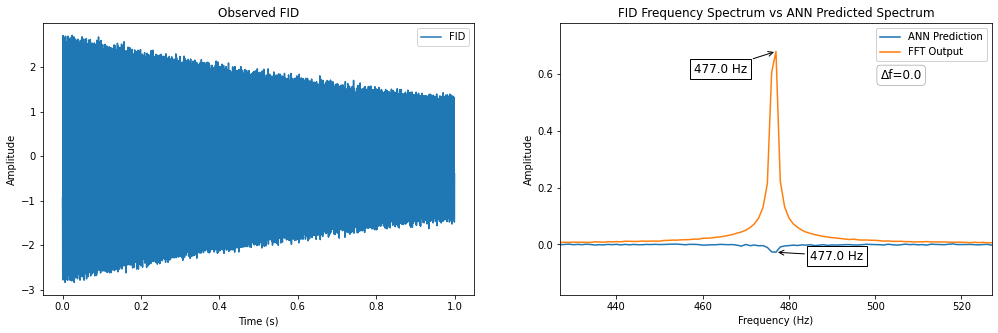

In [31]:
#@title ANN Predictions Visualized
#@markdown Press the `Play` button on the left side of the cell to visualize the ANN predictions for a randomly generated FID. On the left is the submitted FID, and on the right is a superimposition of the ANN prediction and the real FFT output for that FID.
#@markdown The frequency in the ANN Prediction callout is the center frequency predicted by the network. Check the results of hyperparameter tuning against the output in this figure.
#@markdown
#@markdown ---
#@markdown **Exercise 1.1.6** Run this code several times and observe how the network's estimated resonant frequency compares to the real frequency from the FFT.
n_samples = len(test_fid_table)
rand_idx = rng.integers(low = 0, high = n_samples)
rand_sample = test_fid_table[rand_idx]

nn_test = nn_fft(rand_sample)
ft_real = make_window(np.abs(np.fft.fft(rand_sample)/len(rand_sample)))

nn_peak_at = np.argmax(np.abs(nn_test))
ft_peak_at = np.argmax(ft_real)
peak_mean = np.mean([nn_peak_at, ft_peak_at])

nn_freq = xfrq[nn_peak_at]
ft_freq = xfrq[ft_peak_at]

#*_, axis = plt.subplots(1, 3, figsize = (24, 5))
*_, axis = plt.subplots(1, 2, figsize = (17, 5))
sb.lineplot(x = time, y = rand_sample, ax = axis[0], label = 'FID')
sb.lineplot(x = xfrq, y = nn_test, ax = axis[1], label = f'ANN Prediction')
sb.lineplot(x = xfrq, y = ft_real, ax = axis[1], label = f'FFT Output')

axis[0].set(title="Observed FID", xlabel="Time (s)", ylabel="Amplitude")
axis[1].set(title="FID Frequency Spectrum vs ANN Predicted Spectrum", xlabel="Frequency (Hz)", ylabel="Amplitude")

# Annotations
arrow_args = dict(arrowstyle='->')
bbox_args = dict(boxstyle='square', fc='white')
bbox_args2 = dict(boxstyle='round', fc='white', edgecolor='gray', linewidth = 0.5)

nn_amp = nn_test[nn_peak_at]
ft_amp = ft_real[ft_peak_at]

if (nn_amp < 0): 
  nn_y_annotate = nn_amp - 0.025
else:
  nn_y_annotate = nn_amp + 0.01

axis[1].annotate(f'{nn_freq} Hz', xy=(nn_freq, nn_amp), xytext=(nn_freq + 8, nn_y_annotate), arrowprops=arrow_args, bbox=bbox_args, fontsize=12)
axis[1].annotate(f'{ft_freq} Hz', xy=(ft_freq, ft_amp), xytext=(ft_freq - 19, ft_amp-0.075), arrowprops=arrow_args, bbox=bbox_args, fontsize=12)

first_legend = axis[1].legend()
axis[1].add_artist(first_legend)

axis[1].annotate(f'Δf={np.abs(nn_freq-ft_freq)}', xy=(0.7425, 0.795), xycoords='axes fraction', bbox=bbox_args2, fontsize=12)

# `np.isclose(a, b)` assumed b is the reference value
if np.isclose(nn_peak_at, ft_peak_at, atol = 5):
  axis[1].set_xlim(peak_mean - 50, peak_mean + 50)

if (nn_amp < 0):
  axis[1].set_ylim(nn_amp - 0.15, ft_amp + 0.1)

### Discussion
The neural network with the hyperparameters provided in this module was able to successfully learn the frequency content of the majority of FIDs submitted to the predictor. The network showed little capacity for learning the amplitude or spectral width of the center frequency. Some solutions to this problem are adding more layers or further tuning of the hyperparameters.

There exists an alternative to the approach above. Rather than training the network on the FID and its corresponding frequency spectrum, a network may be trained on the FID and the information one expects to discern from the spectrum.

This approach is advantageous because it significantly reduces the number of outputs, and subsequently the number of training parameters. The next exercise in this module will explore this approach in more depth.

# **Exercise 2** Estimation of Lorentzian Curve Fitting Parameters from FID Frequency Spectra

In the previous exercise, it was found that the ANN failed to produce meaningful estimates of the amplitude and spectral width of the FID's center frequency. This information is important in spectroscopy. For instance, in $^1$H NMR, the area under the peak is proportional to the number of protons producing that peak. The sum of the peak integrals represents the number of hydrogens in a substance, which allows for estimation of a substance's molecular formula. Thus, without accurate amplitude and width data, predicting the center frequency is functionally useless.

## Curve Fitting of NMR Data

Determining the location, amplitude, and spectral width of a spectrum's resonant frequency is easily done by fitting the peak to a spectral line shape function. The most common line shapes encountered in NMR are *Lorentzian*, *Gaussian*, and *Voigt*.

\
#### **Lorentzian Distribution**
The Lorentzian line shape function is given by its probability density function (PDF),

\begin{equation}
  L(x; x_0, A, \gamma) = \frac{A}{\pi}\left(\frac{\gamma}{(x-x_0)^2 + \gamma^2}\right)
\end{equation}

where $x_0$ is the location of the resonant frequency, $A$ is the amplitude, and $\gamma$ is the FWHM corresponding to the spectral width.

\
#### **Gaussian Distribution**
Gaussian line shapes are similarly given by their PDF as

\begin{equation}
  G(x; \mu, A, \sigma) = \frac{A}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(x-\mu)^2)}{2\sigma^2}\right)
\end{equation}

where $\mu$ corresponds to the location of the resonant frequency, $A$ is again the amplitude, and $\sigma$ is the FWHM describing the spectral width. 

\
#### **Voigt Profile**
The Voigt profile is a convolution of the Lorentzian and Gaussian line shapes, and is given by

\begin{equation}
  V(x; \sigma, \gamma) = \int_{-\infty}^{\infty}\,G(x';\sigma)L(x-x';\gamma)\,dx'
\end{equation}

There is no closed-form expression for the Voigt profile, but may be approximated from the real part of the Faddeeva function $w(z)$,

\begin{equation}
  V(x; \sigma, \gamma) = \frac{\Re\left[w(z)\right]}{\sigma\sqrt{2\pi}}, \qquad z=\frac{x+iy}{\sigma\sqrt{2}}
\end{equation}

Computing $w(z)$ is computationally expensive, so the Voigt profile is most often approximated using a pseudo-Voigt profile,

\begin{equation}
  pV(x; \sigma, \gamma) = \eta G(x;\sigma) + (1-\eta)L(x;\gamma)
\end{equation}

where $\eta$ is a parameter bound between 0 and 1 that shifts the profile towards pure Gaussian or pure Lorentzian when approaching 1 or 0, respectively.

### Lorentzian Fit

The function below defines a Lorentzian line shape that is callable by `scipy.optimize.curve_fit()`. The parameters being estimated are the location of the resonant frequency, the amplitude of the peak, and the width of the peak.

In [32]:
def lorentzian(x, x0, amp, gamma):
    """ Callable Lorentzian distribution for use with `scipy.optimize.curve_fit() """
    loc_param = (x - x0)**2     # est. location param - peak location
    scl_param = gamma**2        # scale param specifying FWHM

    # Probability density function for Lorentzian distribution 
    lorentz_pdf = (amp/PI) * (gamma / (loc_param + scl_param))

    return lorentz_pdf

The curve fitting algorithm provided by `scipy` works best with initial guesses for the parameters. The peak locations and amplitudes may be robustly determined from the `scipy.signal.find_peaks()` peak finding algorithm by thresholding valid peaks to a peak prominence limited by the signal-to-noise ratio (SNR) of the frequency spectrum.

In [33]:
def fit_spectrum_lorentzian(ft_spectrum_table):
    """ Fits the Fourier transform spectrum to a Lorentzian PDF for parameter estimation """
    popt_table = []

    # peak prominence threshold determined from SNR
    snr_pdiff = 0.049

    for spectrum in ft_spectrum_table:
        # Determine index of maximum amplitude
        # peaks = np.argmax(spectrum) # Less robust than peak finding

        # Determines peak based on prominence of peak relative to depth of side lobes
        # Adjust prominence until desired number of peaks are found
        peaks, _ = scipy.signal.find_peaks(
            x           = spectrum, 
            prominence  = snr_pdiff
            )
        amp_at_center_frq = int(peaks[0])

        # Estimate the the amplitude and location (x0) from the amp_at_center_frq
        amp_pred = spectrum[amp_at_center_frq]
        frq_pred = xfrq[amp_at_center_frq]

        # Return optimized parameters, discard covariance matrix
        optimized_parameters, *_ = scipy.optimize.curve_fit(
            f       = lorentzian,
            xdata   = xfrq, 
            ydata   = spectrum, 
            method  = 'lm', 
            p0      = [frq_pred, amp_pred, 100]
        )

        popt_table.append(optimized_parameters)

    return np.asarray(popt_table)

The table of best-fit parameters determined by `scipy.optimize.curve_fit()` is stored in the `opt_params` variable.

In [34]:
opt_params = fit_spectrum_lorentzian(ft_table)

## The Neural Network

The ANN below is of similar architecture to the one used in Exercise 1. The major difference is the number of training parameters in the network. The input layer remains the same as the first network, but the final layer yields only 3 outputs - the location of the resonant frequency, the amplitude of the peak, and the width of the curve.

### Exercise 2

Unlike the linear transformation from an FID to its frequency spectrum in Exercise 1, there exist much more complex relationships between the input and output data in the following ANN due to the addition of a curve-fitting task which the network must learn.

\
Activation functions are especially important for elucidating these complex relationships. Without them, the model behaves as if it only has a single layer and important weights cannot be updated as quickly. In short, the activation functions introduce non-linearity.


---

**Exercise 2.1** Revisit the activation functions introduced in Exercise 1. Tune the `activation` hyperparameter using some of the more advanced functions available in the [Keras Activation Function API](https://keras.io/api/layers/activations/) documentation. Note how these functions alter the model's ability to converge upon a solution.

\
Aside from the activation function, all of the same hyperparameters from the network in Exercise 1.1 exist in this network, e.g. the number of layers and the number of nodes within each layer, the learning rate, momentum, etc.


---

**Exercise 2.2** This model is overfitting. Revisit the discussion on **Regularization** in Exercise 1, and tune the hyperparameters to seek some improvement. Change the `monitor` option in the early stopping callback to monitor `val_loss` instead of `loss`. In addition to the suggestions in Exercise 1, the model may be overly complex or more samples may be needed for training. Again, these are all tunable hyperparameters that may need adjustment over the course of designing the network. Check the tuning results against the figure at the end of this section - run it several times to compare against several randomly selected FIDs. If the results are unsatisfactory, tune the parameters again and continue to attempt to minimize `val_loss`.

In [ ]:
model_lorentzian = keras.models.Sequential([
    keras.layers.Input(
        shape       = observed_fid_table.shape[1],
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/2)),
        activation          = tf.nn.relu,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/4)),
        activation          = tf.nn.relu6,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/8)),
        activation          = tf.nn.relu6,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/16)),
        activation          = tf.nn.selu,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/32)),
        activation          = tf.nn.relu,
        use_bias            = False
    ),
    keras.layers.Dense(
        units               = int(np.ceil(observed_fid_table.shape[1]/128)),
        activation          = tf.nn.relu,
        use_bias            = False
    ),
    keras.layers.Dense(
        activation  = None, # Linear activation in final later - regression-type problem
        units       = opt_params.shape[1],
    )
])

lr_schedule_fit = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate   = 0.2,
    decay_steps             = 50,
    decay_rate              = 0.96,
    staircase               = True
    )

early_stop_callback = keras.callbacks.EarlyStopping(
    # Change this to `val_loss` in order to complete Exercise 2.2
    # Will also need to uncomment `validation_split` in the `history = model_lorentzian.fit(...)` block.
    monitor   = 'loss',
    min_delta = 1e-4, 
    patience  = 10, 
    mode      = 'auto',
    verbose   = 1,
    baseline  = None
    )

model_lorentzian.compile(
    loss        = 'mean_squared_error', 
    optimizer   = tf.keras.optimizers.SGD(
        learning_rate   = lr_schedule_fit,
        momentum        = 0.5,
        clipnorm        = 1.0
        )
    )

history = model_lorentzian.fit(
    x           = observed_fid_table, 
    y           = opt_params, 
    epochs      = 300, 
    batch_size  = 25,
    # Train on 80% of the input data, validate on 20%
    # validation_split  = 0.2,
    callbacks   = [early_stop_callback]
    )

Consider the model summary below. Note how the number of training parameters is significantly smaller compared to the number of training parameters in the network in Exercise 1.

In [36]:
model_lorentzian.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2000)              8000000   
                                                                 
 dense_3 (Dense)             (None, 1000)              2000000   
                                                                 
 dense_4 (Dense)             (None, 500)               500000    
                                                                 
 dense_5 (Dense)             (None, 250)               125000    
                                                                 
 dense_6 (Dense)             (None, 125)               31250     
                                                                 
 dense_7 (Dense)             (None, 32)                4000      
                                                                 
 dense_8 (Dense)             (None, 3)                

### ANN Predictions

An FID may be submitted to the model via the `predict()` method, which will return the neural network's estimation of the frequency spectrum's best curve-fit parameters, in the form 
```
[frequency, amplitude, fwhm]
```
where `amplitude` and `fwhm` correspond to the distribution-specific parameters (e.g. $A$ and $\gamma$ for the Lorentzian line shape) that influence those properties of the curve.

In [37]:
def nn_lorentzian(input):
  prediction = model_lorentzian.predict(input[np.newaxis])[0]
  return prediction

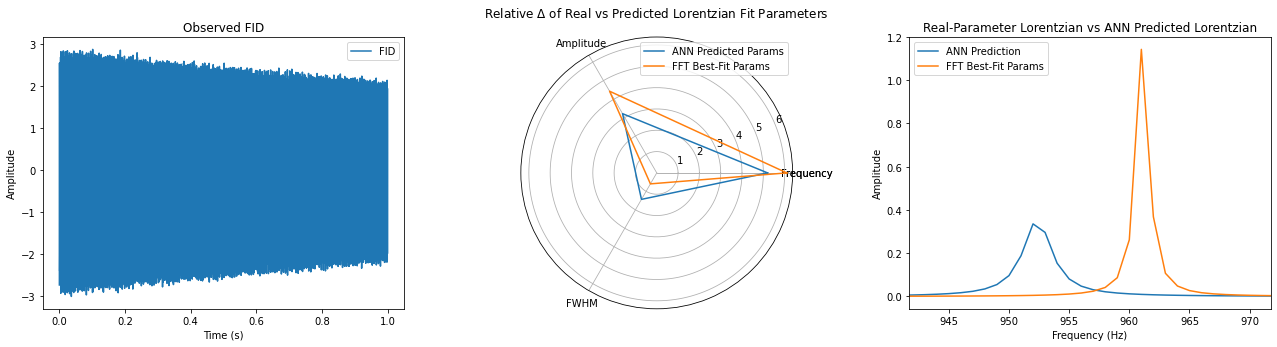

In [120]:
#@title ANN Predictions Visualized
#@markdown Press the `Play` button on the left side of the cell to visualize the ANN predictions for a randomly generated FID. 
#@markdown On the left is the submitted FID, in the center is a radar plot of the real and predicted fit parameters, and on the right is a superimposition of the ANN prediction and the real Lorentzian curve output for the best-fit parameters for the resonant frequency peak of that FID's FFT.
#@markdown Check the results of hyperparameter tuning against the output in this figure.
#@markdown
#@markdown ---
#@markdown **Exercise 1.1.6** Run this code several times and observe how the network's estimated best-fit parameters compare to those determined from the resonant frequency peak of the FID's FFT.
# Be patient - this function takes some time to run
def all_nn_lorentzian(fid_input_table):
  prediction_table = []

  for fid in fid_input_table:
    fid_fit = nn_lorentzian(fid)
    prediction_table.append(fid_fit)

  return prediction_table

nn_test_fit_predictions = all_nn_lorentzian(test_fid_table)
ft_test_fit_actual  = fit_spectrum_lorentzian(transform_fid_table(test_fid_table))

total_sample_num = len(rf_mix_frequency) * len(spin2_relaxation)
test_sample_num = total_sample_num - acq_fid_num

random_sample_n = rng.integers(low = 0, high = test_sample_num)

nn_curve_table = []
ft_curve_table = []

for fit in nn_test_fit_predictions:
  nn = lorentzian(xfrq, fit[0], fit[1], fit[2])
  nn_curve_table.append(nn)

for fit in ft_test_fit_actual:
  ft = lorentzian(xfrq, fit[0], fit[1], fit[2])
  ft_curve_table.append(ft)

random_fid        = test_fid_table[random_sample_n]
random_nn_output  = nn_curve_table[random_sample_n]
random_ft_output  = ft_curve_table[random_sample_n]

#*_, ax = plt.subplots(1, 2, figsize = (17, 5))
fig = plt.figure(figsize=(22,5))
ax0 = plt.subplot(131)
sb.lineplot(x = time, y = random_fid, ax = ax0, label = 'FID')

def make_wrap(lst):
  return (lambda x: [*x, x[0]])(lst)

curve_params = make_wrap(['Frequency', 'Amplitude', 'FWHM'])

nn_test_fit_predictions_mutate  = np.copy(nn_test_fit_predictions)
ft_test_fit_actual_mutate       = np.copy(ft_test_fit_actual)

for prediction in nn_test_fit_predictions_mutate:
  prediction[0] = int(repr(int(prediction[0]))[-2:])/10
  prediction[1] *= 2
  #prediction[0] /= 1000
  #prediction[0] = np.log(np.log(prediction[0]))

for bestfit in ft_test_fit_actual_mutate:
  bestfit[0] = int(repr(int(bestfit[0]))[-2:])/10
  bestfit[1] *= 2
  #bestfit[0] /= 1000
  #bestfit[0] = np.log(np.log(bestfit[0]))

netw_params = make_wrap(nn_test_fit_predictions_mutate[random_sample_n])
real_params = make_wrap(ft_test_fit_actual_mutate[random_sample_n])

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(netw_params))

#plt.figure(figsize=(8, 8))
ax3 = plt.subplot(132, polar=True)
plt.plot(label_loc, netw_params, label='ANN Predicted Params')
plt.plot(label_loc, real_params, label='FFT Best-Fit Params')
plt.title('Relative $\Delta$ of Real vs Predicted Lorentzian Fit Parameters')
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=curve_params)
plt.legend()


ax1 = plt.subplot(133)
sb.lineplot(x = xfrq, y = random_nn_output, ax = ax1, label = f'ANN Prediction')
sb.lineplot(x = xfrq, y = random_ft_output, ax = ax1, label = f'FFT Best-Fit Params')


ax0.set(title="Observed FID", xlabel="Time (s)", ylabel="Amplitude")
ax1.set(title="Real-Parameter Lorentzian vs ANN Predicted Lorentzian", xlabel="Frequency (Hz)", ylabel="Amplitude")

mn = np.mean([nn_test_fit_predictions[random_sample_n][0], ft_test_fit_actual[random_sample_n][0]])
xmin = mn - 15
xmax = mn + 15
ax1.set_xlim(xmin, xmax)

plt.show()

### Discussion

Overall, the network trained on the curve fitting parameters reconstructs the frequency content of the FIDs with much higher fidelity - including the width and amplitude of the peak - than the network trained directly on the spectrum. Both networks display significant room for improvement; however, as was stressed earlier in this module, DFT computation is a poor application for a neural network due to the efficiency and exactness of modern FFT implementations. Nonetheless, the network in Exercise 2 that predicts parameters of best fit is a better problem domain for deep learning, and takes advantage of an ANN's ability to learn complex, nonlinear relationships within data.

\
Outside of the network hyperparameters, one possible area of improvement for the network is the line shape function to which the spectrum is fit. A Lorentzian distribution was utilized initially, but NMR spectra typically fit the Voigt profile better.

---

**Exercise 2.3** Implement the pseudo-Voigt profile as a `curve_fit()` callable function and fit the spectra. Specific details on SciPy curve fitting may be found in the [SciPy Optimize API](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) documentation. Train the network on the new fit parameters and investigate whether or not - and to what degree - the differences between the learned and real spectra have been resolved. Don't forget to change the number of units in the output layer to account for any potential increase in parameters.

**Exercise 2.4** Would the line shape function be considered a tunable hyperparameter?